# Neural sentence embedding models for biomedical text

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot, random
from scipy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import spacy
from scipy.stats.stats import pearsonr, spearmanr
import pandas as pd
import seaborn as sns
from scipy import stats
import utils
import os

In [26]:
results_overview = {}

## Files and directories

In [14]:
DATA_DIR = '/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/'

# Scores assigned by the human experts for each of the 100 sentence pairs
ANNOTATION_SCORES = 'annotation_scores_from_github.txt'

# Original BIOSSES sentence pairs (no pre-processing)
BIOSSES_SENTENCE_PAIRS = 'biosses_sentence_pairs_test_derived_from_github.txt'

# Pre-processed sentences (lower-case, words and punctuation separated by whitespaces), one sentence per line.
BIOSSES_SENTENCE_PAIRS_PREPROCESSED = 'biosses_sentence_pairs_test_derived_from_github_preprocessed.txt'


In [15]:
# Model checkpoint directory
SKIPTHOUGHT_DIR = '/media/matthias/Big-disk/trained-models/skipthought-model-pmcoa'

# Training files for PMCOA corpus produced by pre-processing script (corpus filtered for line length < 400, hyphens separated)
SKIPTHOUGHT_PREPROCESSING_DIR = '/media/matthias/Big-disk/trained-models/skipthought-model-pmcoa/PMC-OA-filtered-400-hyphens-separated-skip-thoughts-preprocessed'

# Vocab file for PMCOA corpus produced by pre-processing script (corpus filtered for line length < 400, hyphens separated)
SKIPTHOUGHT_VOCAB = 'vocab.txt'

# Expanded vocab file and embedding file for skipthoughts model trained on PMCOA corpus based on google news word2vec model
SKIPTHOUGHT_VOCAB_EXT = 'exp-vocab-google-news/vocab.txt'
SKIPTHOUGHT_EMBEDDINGS = 'exp-vocab-google-news/embeddings.npy'

# Google news word2vec model used for vocab expansion:
GOOGLE_NEWS_MODEL = '/media/matthias/Big-disk/trained-models/word2vec-google-news/GoogleNews-vectors-negative300.bin'

# Script for retrieving the vectors for the BIOSSES sentences
SKIPTHOUGHT_ENCODING = '/home/matthias/Documents/Intelligence/SentEval/examples/skipthoughts_encoding.py'

# PMCOA corpus (filtered for line length < 400, hyphens separated), vocab extension based on Google news word2vec model:
SKIPTHOUGHT_EMBEDDINGS = '/home/matthias/Documents/Intelligence/SDL1-Embeddings/data/BIOSSES-skipthought-PMCOA-400-encodings-exp-vocab-google-news.txt'

# Pre-trained skip-thought vectors:
SKIPTHOUGHT_PRETRAINED = '/media/matthias/Big-disk/trained-models/skipthought-vectors/dictionary.txt'

## Functions

In [82]:
def calculate_cos_sim(x,y):
    cos_sim = (dot(x, y) / (norm(x)*norm(y)))
    return cos_sim

def read_vectors(filename, model=None):
    """Function for reading vectors from .txt file in to a numpy array."""
    if model == None:
        with open(filename, "r", encoding="utf-8") as f:
            vectors = np.loadtxt(f)
    # first column needs to be removed from PV vector output files 
    if model == 'PV':
        vectors = []
        for line in open(filename):
            vectors.append(line.split(" ")[1:])
        vectors = vectors[1:]
        vectors = np.array(vectors, dtype=float)
    if model == 'Fasttext':
        vector = []
        words = []
        for line in open(filename, 'r', encoding="utf8"):
            vector.append(line.split()[1:])
            words.append(line.split(None, 1)[0])
            vectors = np.array(vector).astype(np.float)
    return vectors

def calculate_vector_similarity(vectors):
    """Function for calculating the cosine similarity between vectors of each sentence pair and storing them in the list cos_sim. 
    Starting with index 0, two censecutive sentences form a sentence pair, e.g., 
    vectors[0] + vectors[1], vectors[2] + vectors[3], etc. 
    Returns a numpy array with dimension (number of vectors/2,)"
    """
    cos_sim = []
    i= 0
    while (i <= vectors.shape[0]-1):
        cos_sim.append(calculate_cos_sim(vectors[i], vectors[i+1]))                      
        #print(cosine_similarity([vectors[i]], [vectors[i+1]], dense_output=True)[0])
        i += 2
    cos_sim = np.array(cos_sim, dtype=float)
    return cos_sim

def calculate_ppmc(x, y):
    """Returns the PPMC and p-value."""
    
    ppmc, ppmc_p = pearsonr(x, y)
    return (ppmc, ppmc_p)

def calculate_spearman(x, y):
    """Returns Spearman correlation and p-value."""
    
    spearman, spearman_p = spearmanr(x, y)
    return (spearman, spearman_p)

def plot_correlation(annotation_scores, similarities, alpha=0.5):
    plt.subplots(figsize=(4,4))
    c = sns.regplot(x=annotation_scores, y=similarities, scatter_kws={"s": 14})
    c.set_xlabel("Annotation scores.",fontsize=10)
    c.set_ylabel("Calculated similarity",fontsize=10)
    c.axes.set_title("Correlation between given similarities and scores assigned by human annotators.",fontsize=11)
    c.tick_params(labelsize=10)
    return plt.show()

def evaluate_similarities(similarities, name = None):
    """Calculate PPMC and Spearman correlation; draw plot"""  
    plot_correlation(annotation_scores, similarities)
    ppmc = calculate_ppmc(similarities, annotation_scores)
    spearman_correlation = calculate_spearman(similarities, annotation_scores)
    
    print("PPMC: " + str(ppmc[0]))
    print("p-value: " + str(ppmc[1]))
    print("Spearman correlation: " + str(spearman_correlation[0]))
    print("p-value: " + str(spearman_correlation[1]))
    
    if name:
        results_overview[name] = round(ppmc[0], 3)
        
def generate_dictionary(files):
    """Generate dictionaries with cosine similarities and means / std"""
    results = {}
    means_and_stds = {}
    for i in files:
        cos, mean_cos, std_cos = calculate_cosines_for_subsets(i)
        results[str(i)]= cos
        means_and_stds[str(i)] = [mean_cos, std_cos]
    return results, means_and_stds

def calculate_cosines_for_subsets(file):
    """Calculate cosine similarities and means for antonym and negation subsets"""
    if os.path.splitext(file)[1] == '.vec':
        vec = PV_read_vectors(file)
    else:
        vec = read_vectors(file)
    cos = calculate_vector_similarity(vec)
    mean_cos = np.mean(cos)
    std_cos = np.std(cos)
    return cos, mean_cos, std_cos

def retrieve_cosines_for_similar_subset(similarities):
    similar_subset_dict = {}
    cos = []
    for j in similarities.keys():
        cos = []
        for i in similar_sentences_idx:
            #print(similarities.get(j)[i])
            cos.append(similarities.get(j)[i])
            mean = np.mean(cos)
            std = np.std(cos) 
            for j in similarities.keys():
                similar_subset_dict[str(j)] = [cos, mean, std]
    return similar_subset_dict

def pool_vectors(word_vectors, pooling_method):
    pooled_vectors =[]
    i = 0
    k = 0 
    if pooling_method == "max":
        while i < len(sent):
            pooled_vectors.append(np.amax(word_vectors[k:k+len(sent[i])], axis = 0))
            k+=len(sent[i])
            i+=1
    if pooling_method == "min":
        while i < len(sent):
            pooled_vectors.append(np.amin(word_vectors[k:k+len(sent[i])], axis = 0))
            k+=len(sent[i])
            i+=1
    if pooling_method == "sum":
        while i < len(sent):
            pooled_vectors.append(np.sum(word_vectors[k:k+len(sent[i])], axis = 0))
            k+=len(sent[i])
            i+=1
    if pooling_method == "avg":
        while i < len(sent):
            pooled_vectors.append(np.average(word_vectors[k:k+len(sent[i])], axis = 0))
            k+=len(sent[i])
            i+=1
    return pooled_vectors


def read_scores(filename):
    with open(filename, "r", encoding="utf-8") as f:
        scores = np.loadtxt(f)
    return scores

## Annotation scores

In [81]:
# Read scores assigned by human experts for the 100 sentence pairs into np.array
annotation_sores = read_scores(os.path.join(DATA_DIR, ANNOTATION_SCORES))

## Pre-processed BIOSSES sentences

In [18]:
sent = []
with open(os.path.join(DATA_DIR, BIOSSES_SENTENCE_PAIRS_PREPROCESSED), 'r', encoding='utf8') as sentences:
    for line in sentences:
        sent.append(line.split())

## Sent2vec model

### Trained on PMCOA (filtered for <200 line-length) post-processed to separate all hyphens, 1000d

In [13]:
%%bash
../sent2vec/fasttext print-sentence-vectors '/media/matthias/Big-disk/trained-models/complete_PMC_OA_filtered_hyphens_separated--d1000--ngr2--ep9--minc50--thr20--buck4000000--drop4--t1e-06.bin'  < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/sent2vec_vectors_PMCOA_200_hyphens_separated--sent2vec--d1000.txt

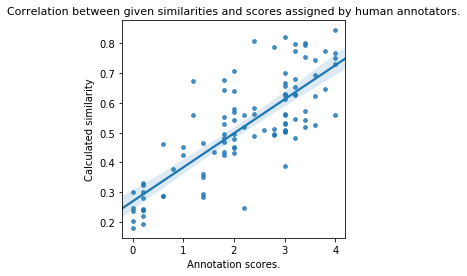

PPMC: 0.7983947507195188
p-value: 2.5734806529254425e-23
Spearman correlation: 0.7632704036821258
p-value: 2.675986915269548e-20


In [83]:
sent2vec_vectors_PMCOA = read_vectors("data/sent2vec_vectors_PMCOA_200_hyphens_separated--sent2vec--d1000.txt")
sent2vec_cosines = calculate_vector_similarity(sent2vec_vectors_PMCOA)
np.savetxt(os.path.join(DATA_DIR, 'cosines-sent2vec-200-1000d.csv'), sent2vec_cosines)
evaluate_similarities(sent2vec_cosines, "Sent2Vec")

## Skipthought (2400D, unidirectional)

Implementation used: https://github.com/tensorflow/models/tree/master/research/skip_thoughts

### Skipthoughts model trained on PMC OA corpus (filtered for <400 chars per line, hyphens separated), Googlenews word2vec model vocab extension

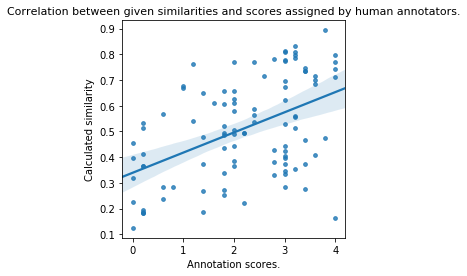

PPMC: 0.47552212086004425
p-value: 5.744263664803008e-07
Spearman correlation: 0.44860058311438983
p-value: 2.8567669683407507e-06


In [84]:
skipthought_vectors = read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-400-encodings-exp-vocab-google-news.txt")
skipthought_cosines = calculate_vector_similarity(skipthought_vectors)
np.savetxt(os.path.join(DATA_DIR, 'cosines-skipthought-400-vocab-ext.csv'), skipthought_cosines)
evaluate_similarities(skipthought_cosines, "Skipthoughts model, 400 corpus, with vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <400 chars per line, hyphens separated), no vocab extension

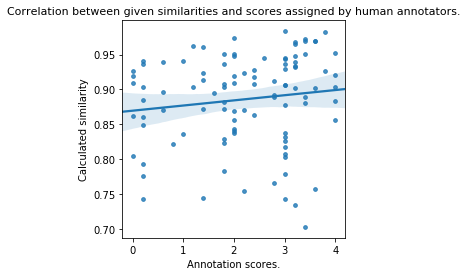

PPMC: 0.13289732297512036
p-value: 0.18746352385352877
Spearman correlation: 0.18963082689112828
p-value: 0.05880466128418115


In [85]:
skipthought_vectors_PMCOA = read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-400-encodings-without-vocab-exp.txt")
skipthought_cosines = calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(DATA_DIR, 'cosines-skipthought-400.csv'), skipthought_cosines)
evaluate_similarities(skipthought_cosines, "Skipthoughts model, 400 corpus, no vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <1000 chars per line, hyphens separated), Googlenews word2vec model vocab extension

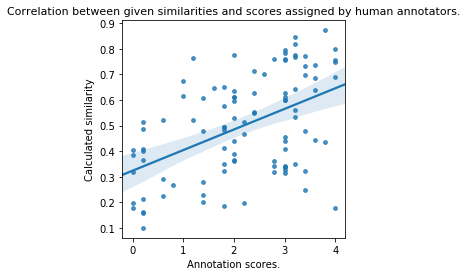

PPMC: 0.48469683665995966
p-value: 3.2204470310209733e-07
Spearman correlation: 0.4598297546413312
p-value: 1.4876502920898309e-06


In [86]:
skipthought_vectors_PMCOA = read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-1000-encodings-exp-vocab-google-news.txt")
skipthought_cosines = calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(DATA_DIR, 'cosines-skipthought-1000-vocab-ext.csv'), skipthought_cosines)
evaluate_similarities(skipthought_cosines, "Skipthoughts model, 1000 corpus, with vocab extension")

### Skipthoughts model trained on PMC OA corpus (filtered for <1000 chars per line, hyphens separated), no vocab extension

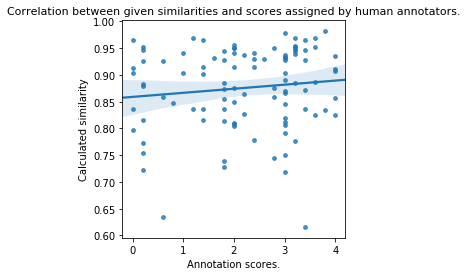

PPMC: 0.11786324457889677
p-value: 0.24285114455560636
Spearman correlation: 0.141183939863412
p-value: 0.16117879368837


In [87]:
skipthought_vectors_PMCOA = read_vectors("/home/matthias/Documents/Intelligence/SDL1 - Embeddings/data/BIOSSES-skipthought-PMCOA-1000-encodings-no-vocab-extension.txt")
skipthought_cos_sim_PMCOA_1000 = calculate_vector_similarity(skipthought_vectors_PMCOA)
np.savetxt(os.path.join(DATA_DIR, 'cosines-skipthought-1000.csv'), skipthought_cos_sim_PMCOA_1000)
evaluate_similarities(skipthought_cos_sim_PMCOA_1000, "Skipthoughts model, 1000 corpus, no vocab extension")

## Skipgram (Fasttext)

Note: Vector dimensions: 300; outputs a file where each line contains a word followed by the vectors for this word. Each sentence would then be represented by an array with dimension (number of words in sentence, 300), e.g.:

S1 [  
W1 [1 .... 300]  
W2 [1 .... 300]  
W3 [1 .... 300]  
W4 [1 .... 300]  
]

### Skipgram word vectors with Fasttext

In [39]:
%%bash
../fastText/fasttext print-word-vectors '/media/matthias/Big-disk/trained-models/fastText-models/PMCOA--fasttext--skipgram.bin' < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/fasttext_skipgram.txt

In [19]:
vectors = []
words = []

with open ('data/fasttext_skipgram.txt', 'r', encoding="utf8") as cbow_vectors:
    for line in cbow_vectors:
        vectors.append(line.split()[1:])
        words.append(line.split(None, 1)[0])

vectors = np.array(vectors)
vectors = vectors.astype(np.float)

print(vectors.shape)


(5696, 100)


In [27]:
# Calculate the cosine similarity between pooled word vectors of each sentence pair generated with fasttext

fasttext_max_pooled_vectors = pool_vectors(vectors, "max")
fasttext_max_pooling_cos_sim = calculate_vector_similarity(np.array(fasttext_max_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-skip-gram-max-pooling.csv'), fasttext_max_pooling_cos_sim)

fasttext_min_pooled_vectors = pool_vectors(vectors, "min")
fasttext_min_pooling_cos_sim = calculate_vector_similarity(np.array(fasttext_min_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-skip-gram-min-pooling.csv'), fasttext_min_pooling_cos_sim)

fasttext_sum_pooled_vectors = pool_vectors(vectors, "sum")
fasttext_sum_pooling_cos_sim = calculate_vector_similarity(np.array(fasttext_sum_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-skip-gram-sum-pooling.csv'), fasttext_sum_pooling_cos_sim)

fasttext_avg_pooled_vectors = pool_vectors(vectors, "avg")
fasttext_avg_pooling_cos_sim = calculate_vector_similarity(np.array(fasttext_avg_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-skip-gram-avg-pooling.csv'), fasttext_avg_pooling_cos_sim)

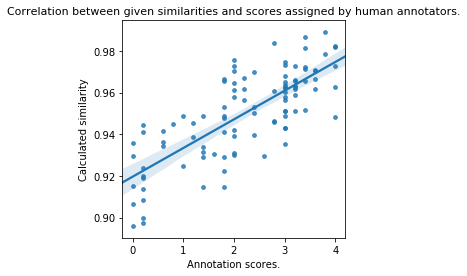

PPMC: 0.7663551988078042
p-value: 1.5270803900583836e-20
Spearman correlation: 0.750890603527692
p-value: 2.339651270003328e-19


In [88]:
evaluate_similarities(fasttext_max_pooling_cos_sim, "skip-gram max pooling")

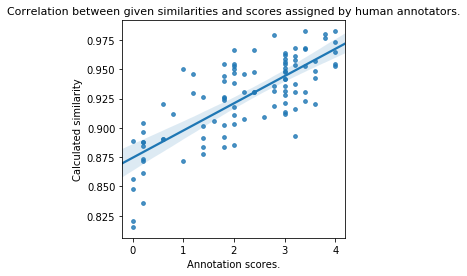

PPMC: 0.7627024804223499
p-value: 2.964372080726015e-20
Spearman correlation: 0.7201248422679871
p-value: 3.072973782411174e-17


In [89]:
evaluate_similarities(fasttext_min_pooling_cos_sim, "skip-gram min pooling")

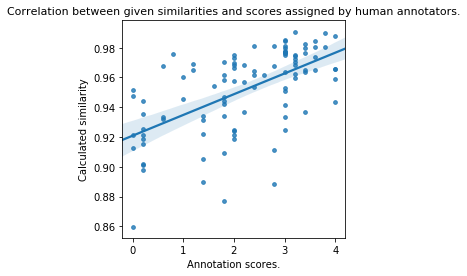

PPMC: 0.588309362462261
p-value: 1.223361973605616e-10
Spearman correlation: 0.6120802117230864
p-value: 1.3235379027230043e-11


In [90]:
evaluate_similarities(fasttext_avg_pooling_cos_sim, "skip-gram avg pooling")

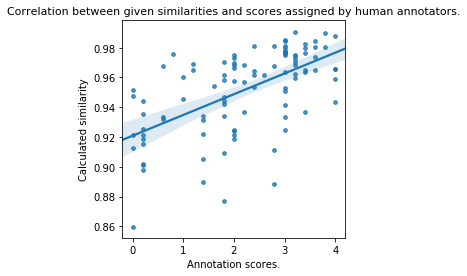

PPMC: 0.5883093624622613
p-value: 1.223361973605575e-10
Spearman correlation: 0.6120802117230864
p-value: 1.3235379027230043e-11


In [91]:
evaluate_similarities(fasttext_sum_pooling_cos_sim, "skip-gram sum pooling")

## CBOW (Fasttext)

In [241]:
%%bash
../fastText/fasttext print-word-vectors '/media/matthias/Big-disk/trained-models/fastText-models/PMCOA--fasttext--cbow.bin' < data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt > data/fasttext_cbow_new.txt

In [32]:
vectors = []
words = []

with open ('data/fasttext_cbow_new.txt', 'r', encoding="utf8") as cbow_vectors:
    for line in cbow_vectors:
        vectors.append(line.split()[1:])
        words.append(line.split(None, 1)[0])

vectors = np.array(vectors)
vectors = vectors.astype(np.float)

print(vectors.shape)


(5696, 100)


In [33]:
# Calculate the cosine similarity between pooled word vectors of each sentence pair generated with fasttext

cbow_max_pooled_vectors = pool_vectors(vectors, "max")
cbow_max_pooling_cos_sim = calculate_vector_similarity(np.array(cbow_max_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-cbow-max-pooling.csv'), fasttext_max_pooling_cos_sim)

cbow_min_pooled_vectors = pool_vectors(vectors, "min")
cbow_min_pooling_cos_sim = calculate_vector_similarity(np.array(cbow_min_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-cbow-min-pooling.csv'), fasttext_min_pooling_cos_sim)

cbow_sum_pooled_vectors = pool_vectors(vectors, "sum")
cbow_sum_pooling_cos_sim = calculate_vector_similarity(np.array(cbow_sum_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-cbow-sum-pooling.csv'), fasttext_sum_pooling_cos_sim)

cbow_avg_pooled_vectors = pool_vectors(vectors, "avg")
cbow_avg_pooling_cos_sim = calculate_vector_similarity(np.array(cbow_avg_pooled_vectors))
np.savetxt(os.path.join(DATA_DIR, 'cosines-fasttext-cbow-avg-pooling.csv'), fasttext_avg_pooling_cos_sim)


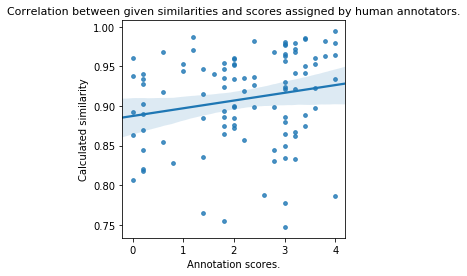

PPMC: 0.19561788879502798
p-value: 0.0511198048361282
Spearman correlation: 0.2592649436721993
p-value: 0.009194041702699877


In [92]:
evaluate_similarities(cbow_max_pooling_cos_sim, "CBOW max pooling")

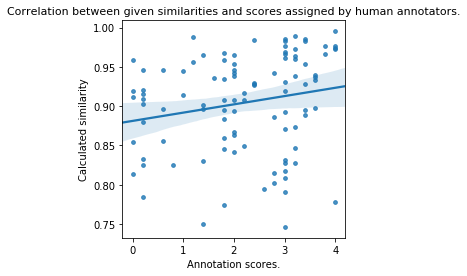

PPMC: 0.19945687647351426
p-value: 0.04664263396883687
Spearman correlation: 0.2744640851756721
p-value: 0.005720030310078099


In [93]:
evaluate_similarities(cbow_min_pooling_cos_sim, "CBOW min pooling")

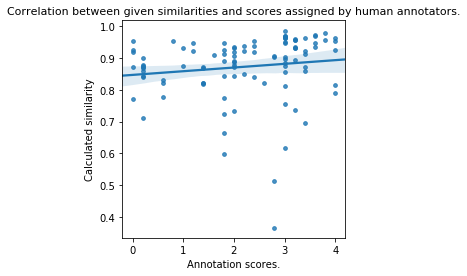

PPMC: 0.1350773469844445
p-value: 0.18026455950882378
Spearman correlation: 0.348513965223507
p-value: 0.00038026894740676454


In [94]:
evaluate_similarities(cbow_sum_pooling_cos_sim, "CBOW sum pooling")

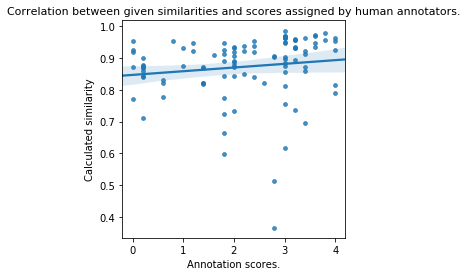

PPMC: 0.1350773469844446
p-value: 0.18026455950882378
Spearman correlation: 0.348513965223507
p-value: 0.00038026894740676454


In [95]:
evaluate_similarities(cbow_avg_pooling_cos_sim, "CBOW avg pooling")

## Paragraph Vector

### PV-DM

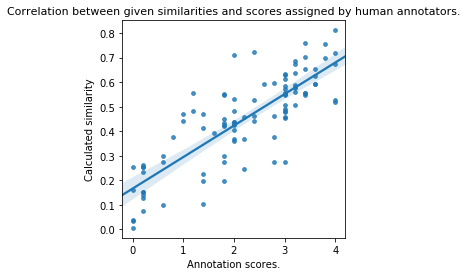

PPMC: 0.819118023673488
p-value: 2.1643133838569955e-25
Spearman correlation: 0.8132956399266119
p-value: 8.796416165030581e-25


In [96]:
pvddm_vectors = read_vectors('data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txt.vec', model='PV')
pvddm_cosines = calculate_vector_similarity(pvddm_vectors)
np.savetxt(os.path.join(DATA_DIR, 'cosines-pv-dm.csv'), pvddm_cosines)
evaluate_similarities(pvddm_cosines, "Paragraph vector model DM, 200 corpus, 100d")

### PV-DBOW

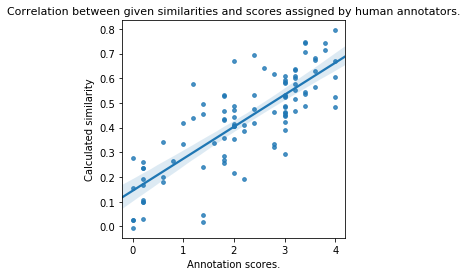

PPMC: 0.8041816284826073
p-value: 7.179169048117732e-24
Spearman correlation: 0.7948313637838674
p-value: 5.534064700608438e-23


In [97]:
pvdbow_vectors = read_vectors('data/biosses_sentence_pairs_test_derived_from_github_preprocessed.txtskipgram.vec', model='PV')
pvdbow_cosines = calculate_vector_similarity(pvdbow_vectors)
np.savetxt(os.path.join(DATA_DIR, 'cosines-pv-dbow.csv'), pvdbow_cosines)
evaluate_similarities(pvdbow_cosines, "Paragraph vector model DBOW 200 corpus, 100d")


## Compare with some scores generated by BIOSSES team

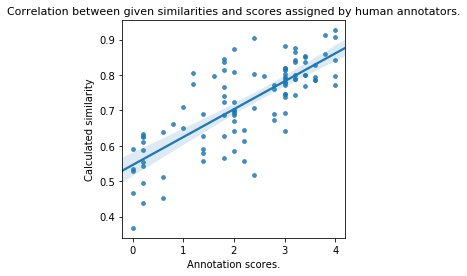

PPMC: 0.7702050786820909
p-value: 7.490648576404794e-21
Spearman correlation: 0.7297154222416409
p-value: 7.21657853871982e-18


In [98]:
evaluate_similarities(read_scores(os.path.join(DATA_DIR, 'biosses-results/paragraphVector.txt')))

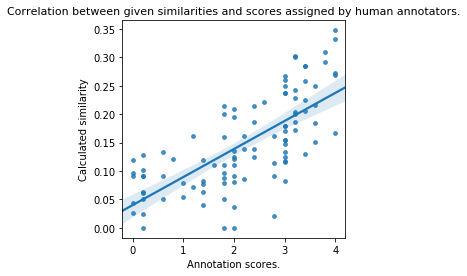

PPMC: 0.7103868044228283
p-value: 1.2597388033307344e-16
Spearman correlation: 0.7535278316096162
p-value: 1.4901169783933226e-19


In [99]:
evaluate_similarities(read_scores(os.path.join(DATA_DIR, 'biosses-results/jaccardSW.txt')))  # jaccard after preprocessing strings (stopwords...)

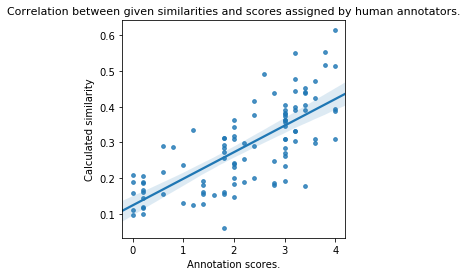

PPMC: 0.7318019321275194
p-value: 5.222458644318889e-18
Spearman correlation: 0.7591257309296925
p-value: 5.611058294380187e-20


In [100]:
evaluate_similarities(read_scores(os.path.join(DATA_DIR, 'biosses-results/qgramSW.txt')))

## Overall results

In [79]:
results_overview_df = pd.DataFrame([results_overview], index=['r']).transpose()
results_overview_df = results_overview_df.sort_values(by=['r'], ascending=False)
results_overview_df.to_csv('results_overview.csv')
results_overview_df

,r
"Paragraph vector model DM, 200 corpus, 100d",0.819
"Paragraph vector model DBOW 200 corpus, 100d",0.804
Sent2Vec,0.798
skip-gram max pooling,0.766
skip-gram min pooling,0.763
skip-gram avg pooling,0.588
skip-gram sum pooling,0.588
"Skipthoughts model, 1000 corpus, with vocab extension",0.485
"Skipthoughts model, 400 corpus, with vocab extension",0.476
CBOW min pooling,0.199
